# WIP: Diabetes Dataset Analysis 

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import pandas_profiling
from sklearn import datasets

In [2]:
dataset = datasets.load_diabetes()

What attributes does the object have:

In [3]:
dir(dataset)

['DESCR', 'data', 'feature_names', 'target']

Standard attributes for a scikit dataset. Let’s see what the notes on the dataset are:

In [4]:
print(dataset.DESCR)

Diabetes dataset

Notes
-----

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani

To summarise the data:
- Only quantitative variables
- Data has been centred and scaled
- y is also quantitative
- six sereum measurements

In [5]:
dataset.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Convert the numpy matrix to a data frame object

In [6]:
df = pd.DataFrame(
    data=dataset.data, 
    index=None, 
    columns=dataset.feature_names
)

Add the target column:

In [7]:
df['y'] = dataset.target

In [8]:
df.head(n=5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Interestingly, `sex` is not binary but takes floating point values. 

What does the profile of the data look like:

In [9]:
pf = pandas_profiling.ProfileReport(df)

In [10]:
pf

Number of variables,11
Number of observations,442
Total Missing (%),0.0%
Total size in memory,38.0 KiB
Average record size in memory,88.1 B
Numeric,10
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


Now that we have some overall statistics for the data, what does the data look like when all columns are plotted against each other?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x198C5230>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1ADBBDD0>]], dtype=object)

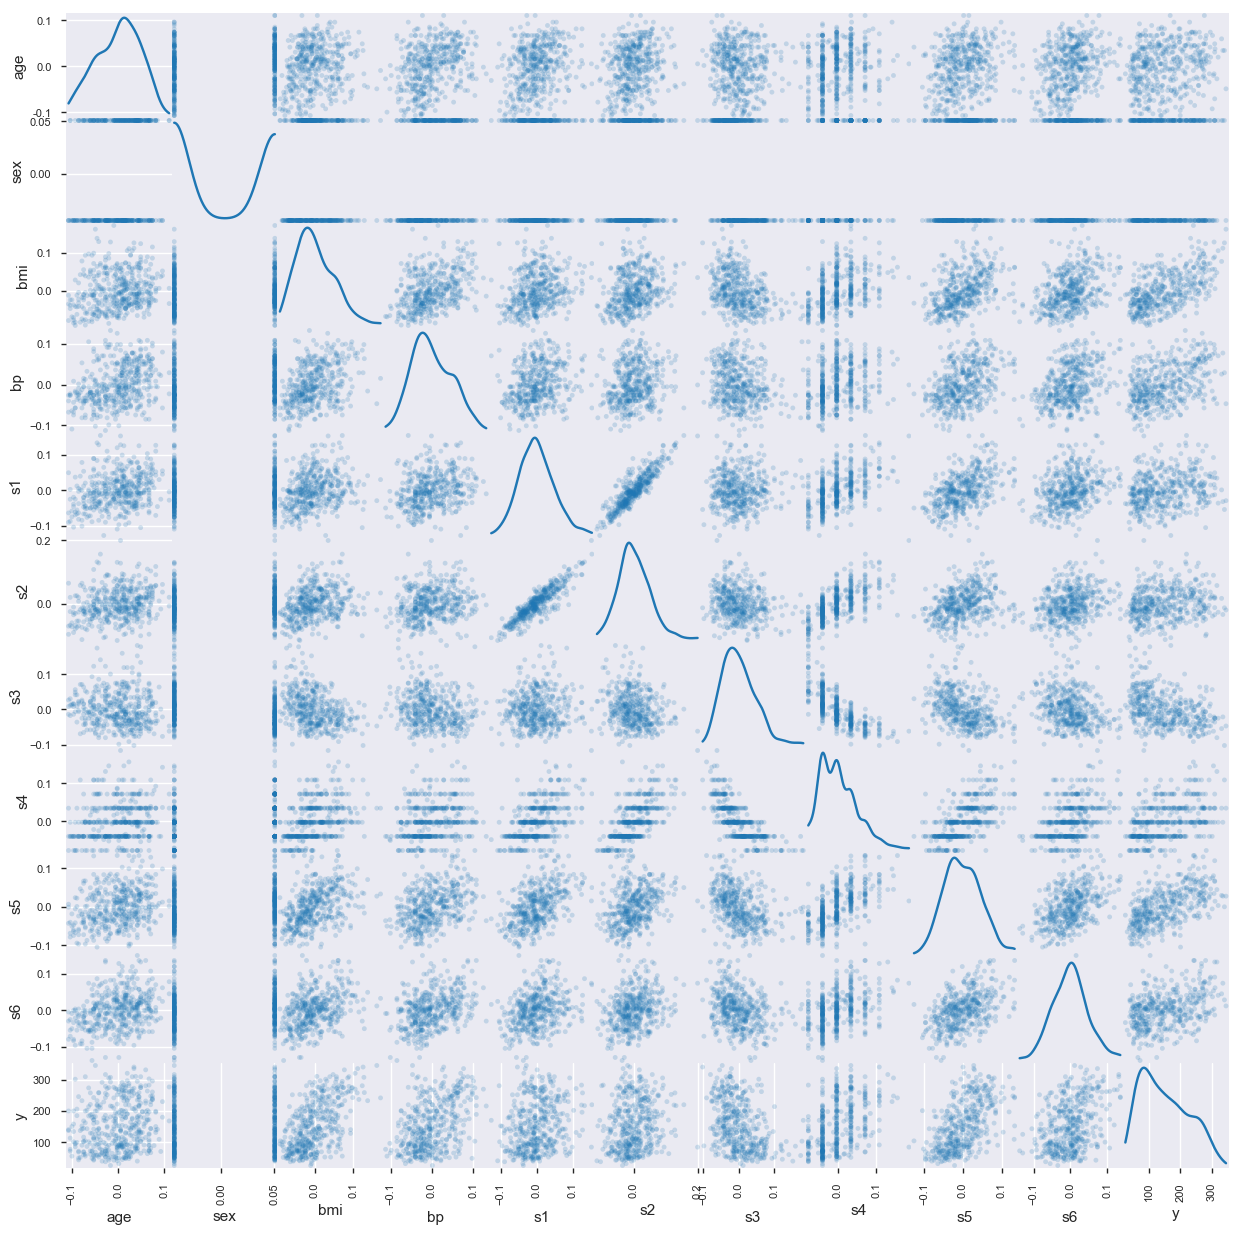

In [11]:
scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

`Sex` unsurprisingly falls onto one of two values, but the interesting feature here is `s4` which has a banding effect. The feature `s3` is the only feature negatively correlated with the other features, especially with `s4`

Let's see if there is any visual separation of the data by `sex`

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1C2008F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1D46EF10>]], dtype=object)

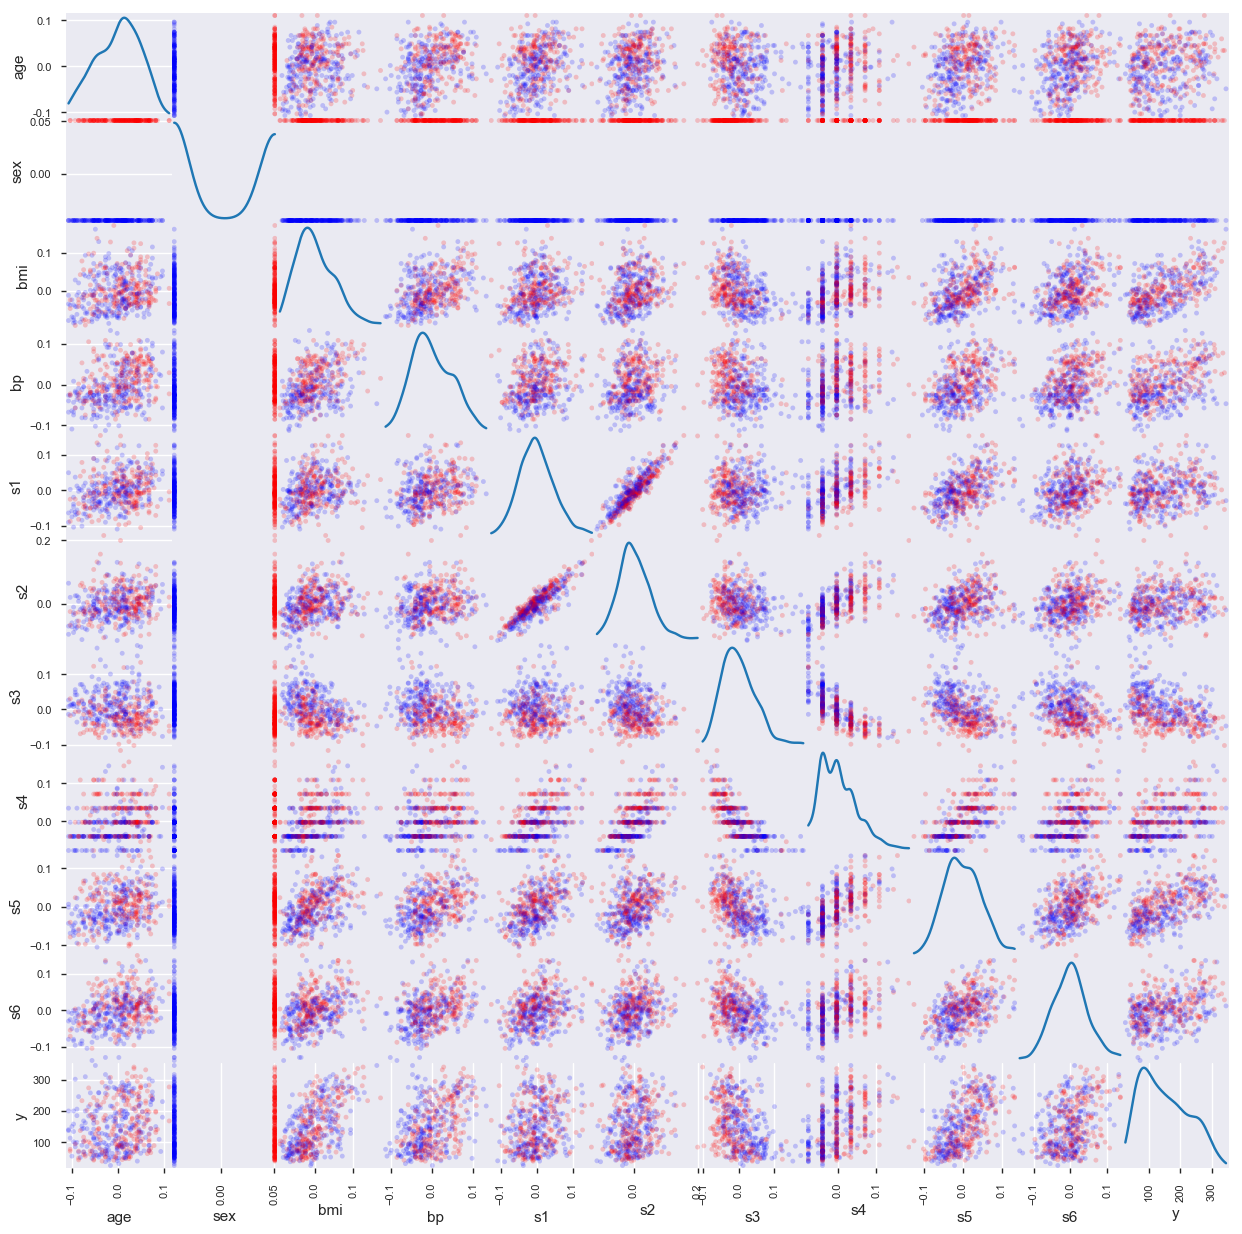

In [12]:
colours = ['red' if i > 0 else 'blue' for i in df['sex']]
scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde', color=colours)

Not really any visual separation by gender

## Lasso Regression

In [13]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1, fit_intercept=False)
lasso_reg.fit(dataset.data, dataset.target)

Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [14]:
lasso_reg.coef_

array([  -0.        , -155.36288234,  517.18201661,  275.08235083,
        -52.54026923,   -0.        , -210.15975349,    0.        ,
        483.91440913,   33.67282148])

In [15]:
from sklearn.linear_model import lasso_path, enet_path
from itertools import cycle
import numpy as np

Lasso coefs not mathching that in `lasso_reg.coef_`

In [16]:
#X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
#y = np.ones(10)

n_alphas = 200
alphas = np.logspace(-5, 1, n_alphas)
#alphas = np.linspace(-100, 100, 200)

coefs = []
for a in alphas:
    lasso_reg_vary_alpha = Lasso(alpha=a, fit_intercept=False)
    lasso_reg_vary_alpha.fit(dataset.data, dataset.target)
    coefs.append(lasso_reg_vary_alpha.coef_)

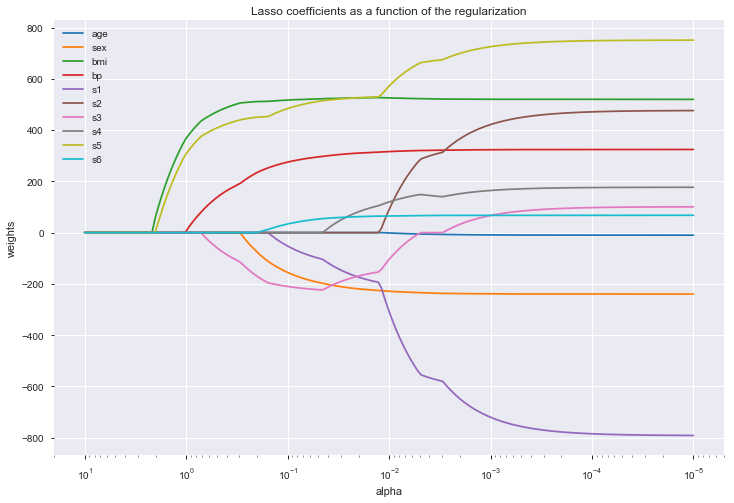

In [19]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.legend([i for i in df.columns[:-1]])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()


Higher alpha, more constrained the weights are

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [21]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


### Quick Linear Regression

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df[['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']], df['y'], random_state=42, shuffle=True)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
pred = lr.predict(X_test)
print(np.sqrt(mean_squared_error(pred, y_test)), mean_squared_error(pred, y_test))

53.369422968 2848.29530793


In [82]:
from sklearn.linear_model import Lasso, LassoCV
lasso_reg = Lasso(alpha=1, fit_intercept=False)
lasso_reg.fit(X_train, y_train)
pred = lasso_reg.predict(X_test)
np.sqrt(mean_squared_error(pred, y_test))

161.05471810855889

### Quick Polynomial Features

In [25]:
from sklearn.preprocessing import PolynomialFeatures

In [26]:
poly_feats = PolynomialFeatures(degree=2, include_bias=False)

In [27]:
X_poly = poly_feats.fit_transform(dataset.data)

In [28]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, dataset.target, random_state=42, shuffle=True, test_size=0.2)

In [29]:
# Linear regression with polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train_poly)
pred_poly = lr_poly.predict(X_test_poly)
np.sqrt(mean_squared_error(pred_poly, y_test_poly))

55.639689843249634

In [30]:
# Lasso with polynomial features
lasso_reg_poly = Lasso(alpha=10, fit_intercept=False)
lasso_reg_poly.fit(X_train_poly,y_train_poly)
lasso_pred_poly = lasso_reg_poly.predict(X_test_poly)
np.sqrt(mean_squared_error(lasso_pred_poly, y_test_poly))

162.93736302537525

In [44]:
np.logspace(-4, 4, 30)

array([  1.00000000e-04,   1.88739182e-04,   3.56224789e-04,
         6.72335754e-04,   1.26896100e-03,   2.39502662e-03,
         4.52035366e-03,   8.53167852e-03,   1.61026203e-02,
         3.03919538e-02,   5.73615251e-02,   1.08263673e-01,
         2.04335972e-01,   3.85662042e-01,   7.27895384e-01,
         1.37382380e+00,   2.59294380e+00,   4.89390092e+00,
         9.23670857e+00,   1.74332882e+01,   3.29034456e+01,
         6.21016942e+01,   1.17210230e+02,   2.21221629e+02,
         4.17531894e+02,   7.88046282e+02,   1.48735211e+03,
         2.80721620e+03,   5.29831691e+03,   1.00000000e+04])

### TODO
- Lasso CV
- Learning Curve
- PCA

In [43]:
from sklearn.model_selection import GridSearchCV

In [47]:
n_alphas = 200
alphas = np.logspace(-5, 1, n_alphas)

In [51]:
data = df[['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']]
target = df['y']

In [52]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_gs = KFold(n_splits=5, random_state=42, shuffle=True)

In [76]:
for train_index, test_index in cv.split(data):
    validation_set_y = target.iloc[test_index]
    validation_set_x = data.iloc[test_index]
    training_set_x = data.iloc[train_index]    
    training_set_y = target.iloc[train_index]
    
    lasso_reg = Lasso(fit_intercept=False)
    gs = GridSearchCV(
        lasso_reg,
        {
            'alpha': alphas,
        },
        scoring='neg_mean_squared_error',
        cv=cv_gs
    )
    gs.fit(training_set_x, training_set_y)
    val_set_pred = gs.predict(validation_set_x)
    print(mean_squared_error(validation_set_y, val_set_pred), np.sqrt(mean_squared_error(validation_set_y, val_set_pred)))

26354.915271 162.341970146
29221.5154102 170.943018021
26885.5436035 163.968117643
27719.1937859 166.490821927
25274.4827911 158.979504312


In [80]:
for train_index, test_index in cv.split(data):
    validation_set_y = target.iloc[test_index]
    validation_set_x = data.iloc[test_index]
    training_set_x = data.iloc[train_index]    
    training_set_y = target.iloc[train_index]
    
    lr = LinearRegression()
    lr.fit(training_set_x, training_set_y)

    pred = lr.predict(validation_set_x)
    print(mean_squared_error(validation_set_y, pred), np.sqrt(mean_squared_error(validation_set_y, pred)))

2900.17328788 53.8532569849
2662.63714463 51.6007475201
3312.2661155 57.5522902715
2797.92365858 52.8954030005
3403.87291807 58.342719495


plain linear regression performs much better than lasso

In [83]:
from sklearn.linear_model import Ridge

In [86]:
ridge_reg = Ridge(alpha=0.0, fit_intercept=False)
ridge_reg.fit(X_train, y_train)
pred = ridge_reg.predict(X_test)
print(mean_squared_error(pred, y_test), np.sqrt(mean_squared_error(pred, y_test)))

27317.1592477 165.279034507
